In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from datetime import time 
import datetime

# dataset obtained from [alfheim](https://datasets.simula.no/alfheim/) 
The dataset contains body-sensor traces and corresponding videos from several professional soccer games captured in late 2013 at the Alfheim Stadium in Tromsø,Norway. It contains per-player statistics of the players like position on the ground, direction facing, speed of the player(in m/s), distance covered so far (in metres) and energy spent.

In [2]:
db = pd.read_csv("2013-11-03_tromso_stromsgodset_first.csv", names = ["timestamp", "playerid", "x_pos", "y_pos", "facing","heading", "energy","speed","total_distance"])


In [3]:
timedf = pd.to_datetime(db["timestamp"]).dt.to_pydatetime()


This step is to convert the time which originally contained the timestamp to the time instance of the match (for example 30th second of the 6th minute in the match instead of the time 18:07:30 )

In [4]:
timedf = [str(timedf[i] - timedf[0]) for i in range(len(timedf))]

In [5]:
timedf = pd.DataFrame(timedf)

In [6]:
timedf.columns

RangeIndex(start=0, stop=1, step=1)

In [7]:
timedf = pd.to_datetime(timedf[0]).dt.time

In [8]:
db["time"] = timedf

In [9]:
timedf

0         00:00:00
1         00:00:00
2         00:00:00
3         00:00:00
4         00:00:00
            ...   
623512    00:47:13
623513    00:47:13
623514    00:47:13
623515    00:47:13
623516    00:47:13
Name: 0, Length: 623517, dtype: object

I will be taking just one player (id 10), and analyse his speed over time. The speed depends on a lot of external factors like how much pressure he is instructed to apply on the opposition, how close he is to recovering the ball , what his physical attributes are , what position he plays etc., While ARIMA doesnt take these factors into account, let's just see what it could do.

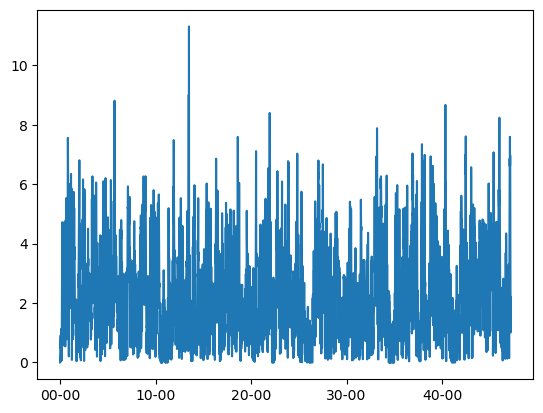

In [10]:
x_dt = [datetime.datetime.combine(datetime.date.today(), t) for t in db[db["playerid"]==10]["time"]]
y_speed = db[db["playerid"]==10]["speed"]
ax = plt.gca()

plt.plot( x_dt, y_speed)

import matplotlib.dates as mdates
ax.xaxis.set_major_formatter(mdates.DateFormatter('%M-%S'))


In [11]:
x_dt = pd.DataFrame(x_dt)

In [12]:
x_dt.values

array([['2023-04-15T00:00:00.000000000'],
       ['2023-04-15T00:00:00.050000000'],
       ['2023-04-15T00:00:00.100000000'],
       ...,
       ['2023-04-15T00:47:12.900000000'],
       ['2023-04-15T00:47:12.950000000'],
       ['2023-04-15T00:47:13.000000000']], dtype='datetime64[ns]')

In [13]:
tsdb = pd.DataFrame([x_dt[0].values, y_speed])
tsdb = pd.DataFrame(tsdb.T)
tsdb = tsdb.rename(columns={0:"time", 1:"speed"})
tsdb["time"] = pd.to_datetime(tsdb["time"])

This step will resample the data whish collected at 5ms intervals to 1minute intervals. the speed corresponding to each minute will be the mean speed over that minute. This is to make sure that we will be able to make sufficient amount of predictions. we could also resample to just one second , but then we would have to increase the time lag parameter of the model in order to predict longer into the future. if the time lag is 10 , and we have samples at 1hz, we would be able to predict for just 10 secs. considering we would have data for 45*60 seconds, it'll seem rather insignificant , and hence i've chosen to go with 1 minute intervals so i could make predictions for say 5 or 10 minutes into the future

In [77]:
df_resampled = tsdb.resample('1T', on='time').mean()

In [78]:
df_resampled.drop("time", inplace = True, axis = 1)

In [79]:
df_resampled

,speed
time,
2023-04-15 00:00:00,2.781964
2023-04-15 00:01:00,2.851138
2023-04-15 00:02:00,2.595297
2023-04-15 00:03:00,2.803589
2023-04-15 00:04:00,2.571407
2023-04-15 00:05:00,3.139975
2023-04-15 00:06:00,1.850461
2023-04-15 00:07:00,2.683885
2023-04-15 00:08:00,3.032529


In [80]:
y_speed = df_resampled["speed"]

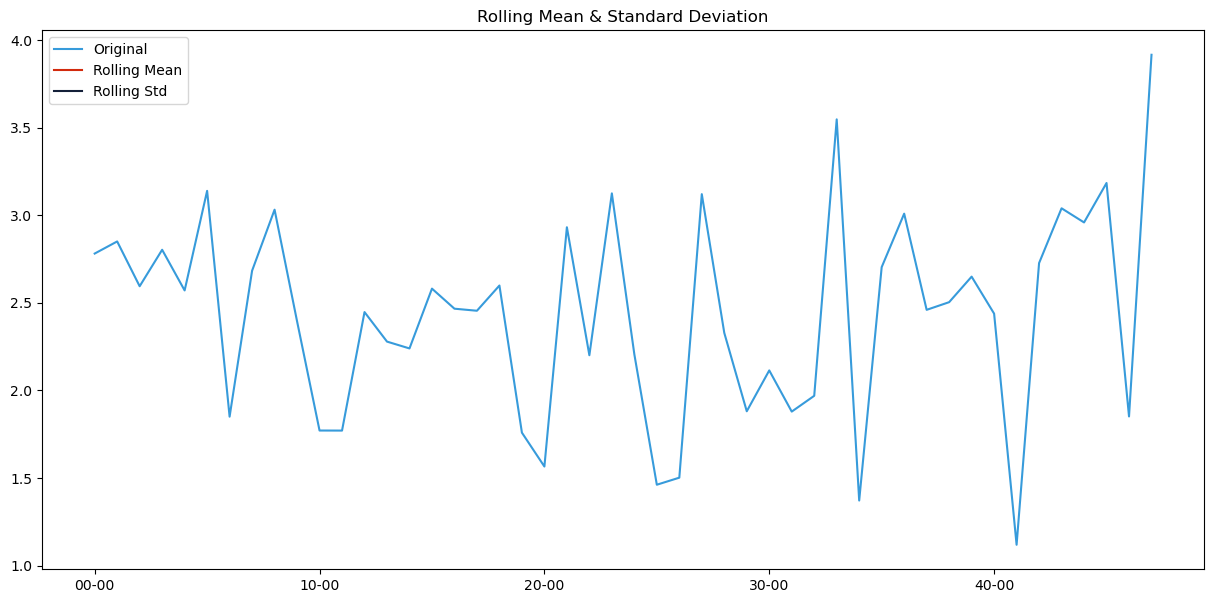

In [81]:
#Determine rolling statistics
df_resampled["rolling_avg"] = df_resampled["speed"].rolling("60s",min_periods=10).mean()
df_resampled["rolling_std"] = df_resampled["speed"].rolling("60s",min_periods=10).std()

#Plot rolling statistics
plt.figure(figsize=(15,7))
plt.plot(y_speed, color='#379BDB', label='Original')
plt.plot(df_resampled["rolling_avg"], color='#D22A0D', label='Rolling Mean')
plt.plot(df_resampled["rolling_std"], color='#142039', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
import matplotlib.dates as mdates
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%M-%S'))
plt.show(block=False)

In [82]:
print('AD-Fuller Test:')
dftest = adfuller(df_resampled["speed"])

print(dftest)

AD-Fuller Test:
(-6.936805278127912, 1.0495438027938084e-09, 0, 47, {'1%': -3.5778480370438146, '5%': -2.925338105429433, '10%': -2.6007735310095064}, 72.8094912875463)


In [83]:
ts_data = df_resampled["speed"] - df_resampled["speed"].shift(2)


In [84]:
adfuller(ts_data.dropna())


(-6.281373318128986,
 3.7892366759648234e-08,
 3,
 42,
 {'1%': -3.596635636000432,
  '5%': -2.933297331821618,
  '10%': -2.6049909750566895},
 79.38608720027682)

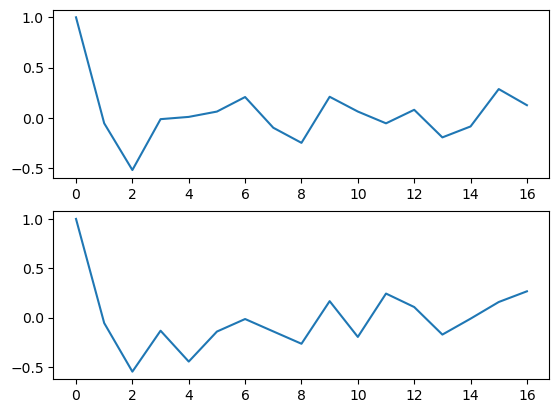

In [85]:
from statsmodels.tsa.stattools import acf,pacf

acf_plot = acf(ts_data.dropna())
pacf_plot = pacf(ts_data.dropna())

plt.subplot(211)
plt.plot(acf_plot)
plt.subplot(212)
plt.plot(pacf_plot)


In [86]:
from pmdarima import auto_arima

In [87]:
model = auto_arima(df_resampled["speed"] ,seasonal=False, trace=True, start_p = 10, max_p = 20)

Performing stepwise search to minimize aic
 ARIMA(10,0,2)(0,0,0)[0]             : AIC=108.226, Time=0.38 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=226.321, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=125.345, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=188.463, Time=0.02 sec
 ARIMA(9,0,2)(0,0,0)[0]             : AIC=110.166, Time=0.30 sec
 ARIMA(10,0,1)(0,0,0)[0]             : AIC=107.511, Time=0.28 sec
 ARIMA(9,0,1)(0,0,0)[0]             : AIC=110.027, Time=0.22 sec
 ARIMA(10,0,0)(0,0,0)[0]             : AIC=inf, Time=0.16 sec
 ARIMA(11,0,1)(0,0,0)[0]             : AIC=109.411, Time=0.37 sec
 ARIMA(9,0,0)(0,0,0)[0]             : AIC=inf, Time=0.12 sec
 ARIMA(11,0,0)(0,0,0)[0]             : AIC=inf, Time=0.18 sec
 ARIMA(11,0,2)(0,0,0)[0]             : AIC=111.381, Time=0.38 sec
 ARIMA(10,0,1)(0,0,0)[0] intercept   : AIC=103.261, Time=0.38 sec
 ARIMA(9,0,1)(0,0,0)[0] intercept   : AIC=105.466, Time=0.35 sec
 ARIMA(10,0,0)(0,0,0)[0] intercept   : AIC=105.097, 

In [88]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   48
Model:              SARIMAX(10, 0, 1)   Log Likelihood                 -38.630
Date:                Sat, 15 Apr 2023   AIC                            103.261
Time:                        13:50:25   BIC                            127.586
Sample:                    04-15-2023   HQIC                           112.453
                         - 04-15-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      1.8040      2.073      0.870      0.384      -2.258       5.866
ar.L1         -0.8961      0.348     -2.573      0.010      -1.579      -0.214
ar.L2         -0.0363      0.304     -0.120      0.905      -0.632       0.560
ar.L3          0.0361      0.316      0.114      0.909      -0.583       0.655
ar.L4          0.0784      0.264      0.297      0.766      -0.438       0.595
ar.L5          0.2095      0.285      0.735      0.462      -0.349       0.768
ar.L6          0.2623      0.296      0.885      0.376      -0.319       0.843
ar.L7          0.1815      0.288      0.631      0.528      -0.383       0.746
ar.L8         -0.0162      0.298     -0.054      0.957      -0.601       0.569
ar.L9          0.1297      0.281      0.461      0.645      -0.422       0.681
ar.L10         0.3381      0.245      1.377      0.168      -0.143       0.819
ma.L1          0.9121      0.266      3.429      0.001       0.391       1.433
sigma2         0.2777      0.084      3.303      0.001       0.113       0.442
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 0.14
Prob(Q):                              0.98   Prob(JB):                         0.93
Heteroskedasticity (H):               2.34   Skew:                            -0.01
Prob(H) (two-sided):                  0.10   Kurtosis:                         2.74
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [91]:
test = df_resampled["speed"][-10:]
train = df_resampled["speed"][:-10]

In [92]:
model.fit(train)

ARIMA(order=(10, 0, 1), scoring_args={}, suppress_warnings=True)

In [93]:
ypred = pd.DataFrame(model.predict(n_periods=1000), index = test.index)

In [94]:
ypred.isna().sum()

0    0
dtype: int64

In [95]:
df_resampled.isnull().sum()

speed           0
rolling_avg    48
rolling_std    48
dtype: int64

In [96]:
ypred

,0
time,
2023-04-15 00:38:00,2.301318
2023-04-15 00:39:00,2.658019
2023-04-15 00:40:00,1.803080
2023-04-15 00:41:00,2.481548
2023-04-15 00:42:00,2.696702
2023-04-15 00:43:00,2.232621
2023-04-15 00:44:00,2.114545
2023-04-15 00:45:00,2.719253
2023-04-15 00:46:00,2.122394


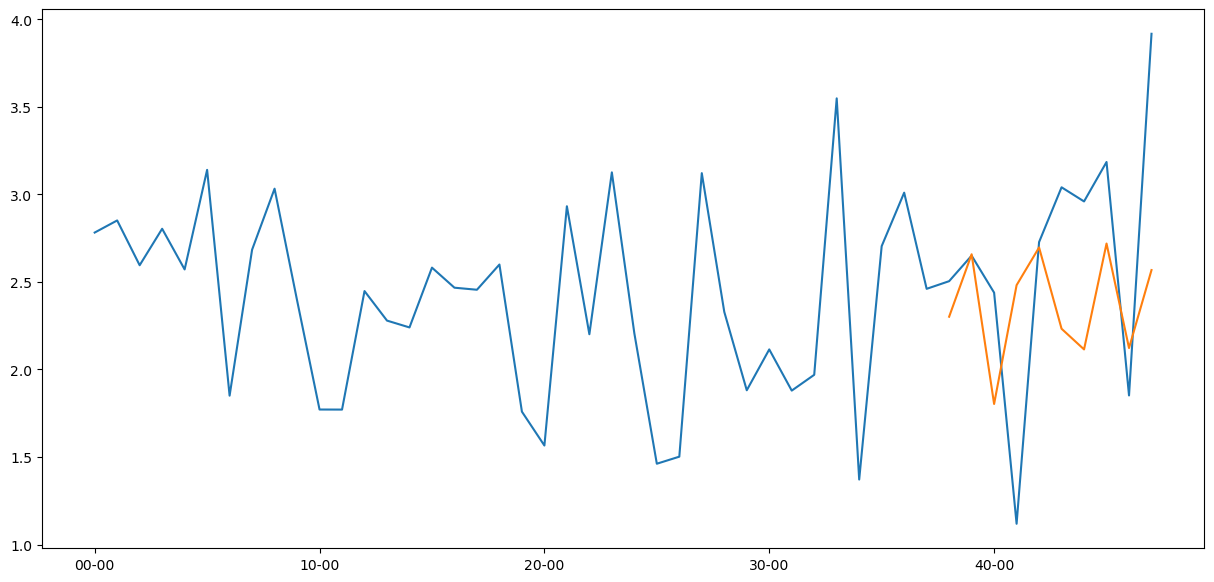

In [97]:
plt.figure(figsize=(15,7))

plt.plot(df_resampled["speed"])
plt.plot(ypred)
import matplotlib.dates as mdates
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%M-%S'))

All things considered, the result is not bad as I expected it to be. It seems to have understood when the player will slow down or run faster, just not the magnitude of the increase/decrease in speed.